# Debugging for +1/-1 Correlations

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from analysis.correlation_of_correlations import *
from common.helpers import get_graphemes, get_phonemes

sns.set_style('darkgrid')

## Load Activation Data

In [3]:
anchor_probe_mapping = pd.read_pickle(f'../../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [4]:
anchors_data = []
for dilution in tqdm(range(1, 4)):
    anchor_list = sum(anchor_probe_mapping['anchor'].apply(lambda x: x[:dilution]).tolist(), [])
    # Load anchors data
    hidden_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-anchors-hidden.pkl'), 
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-hidden.pkl')])
    hidden_data['epoch'] = hidden_data['epoch'].astype(int)
    hidden_data = hidden_data[hidden_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])]
    hidden_data = hidden_data[hidden_data['orth'].isin(anchor_list)]
    hidden_data = hidden_data.drop_duplicates(subset=['epoch', 'orth'])
    
    output_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-anchors-output.pkl'),
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-output.pkl')])
    output_data['epoch'] = output_data['epoch'].astype(int)
    output_data = output_data[output_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])]
    output_data = output_data[output_data['orth'].isin(anchor_list)]
    output_data = output_data.drop_duplicates(subset=['epoch', 'orth'])
    
    activations_data = pd.merge(hidden_data[['epoch', 'orth', 'hidden']], output_data, how='left', on=['epoch', 'orth']).reset_index(drop=True)
    activations_data['dilution'] = dilution
    anchors_data.append(activations_data)
    
anchors_data = pd.concat(anchors_data)
anchors_data = anchors_data.drop(columns=['target'])

100%|██████████| 3/3 [00:20<00:00,  6.79s/it]


In [5]:
probes_data = []
for dilution in range(1, 4):
    # Load anchors data
    hidden_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-probes-hidden.pkl'),
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-hidden.pkl')])
    hidden_data['epoch'] = hidden_data['epoch'].astype(int)
    hidden_data = hidden_data[hidden_data['word_type'].isin(['PRO_REG', 'PRO_EXC', 'PRO_AMB'])]
    hidden_data = hidden_data.drop_duplicates(subset=['epoch', 'orth'])
    
    output_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-probes-output.pkl'),
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-output.pkl')])
    output_data['epoch'] = output_data['epoch'].astype(int)
    output_data = output_data[output_data['word_type'].isin(['PRO_REG', 'PRO_EXC', 'PRO_AMB'])]
    output_data = output_data.drop_duplicates(subset=['epoch', 'orth'])
    
    activations_data = pd.merge(hidden_data[['epoch', 'orth', 'hidden']], output_data, 
                                how='left', on=['epoch', 'orth']).reset_index(drop=True)
    activations_data['dilution'] = dilution
    probes_data.append(activations_data)
    
probes_data = pd.concat(probes_data)
probes_data = probes_data.drop(columns=['target'])

In [6]:
# find input representations
inputs = []
for orth in anchors_data['orth'].unique():
    inputs.append({'orth': orth, 'input': get_graphemes(orth)})
inputs = pd.DataFrame(inputs)
anchors_data = anchors_data.merge(inputs, on='orth')

inputs = []
for orth in probes_data['orth'].unique():
    inputs.append({'orth': orth, 'input': get_graphemes(orth)})
inputs = pd.DataFrame(inputs)
probes_data = probes_data.merge(inputs, on='orth')

In [7]:
# find target representations
targets = []
for phon in anchors_data['phon'].unique():
    targets.append({'phon': phon, 'target': get_phonemes(phon)})
targets = pd.DataFrame(targets)
anchors_data = anchors_data.merge(targets, on='phon')
anchors_data['word_type'] = anchors_data['word_type'].replace({'ANC_REG': 'Regular',
                                                       'ANC_AMB': 'Ambiguous',
                                                       'ANC_EXC': 'Exception',
                                                       'PRO_REG': 'Regular',
                                                       'PRO_AMB': 'Ambiguous',
                                                       'PRO_EXC': 'Exception'})

targets = []
for phon in probes_data['phon'].unique():
    targets.append({'phon': phon, 'target': get_phonemes(phon)})
targets = pd.DataFrame(targets)
probes_data = probes_data.merge(targets, on='phon')
probes_data['word_type'] = probes_data['word_type'].replace({'ANC_REG': 'Regular',
                                                       'ANC_AMB': 'Ambiguous',
                                                       'ANC_EXC': 'Exception',
                                                       'PRO_REG': 'Regular',
                                                       'PRO_AMB': 'Ambiguous',
                                                       'PRO_EXC': 'Exception'})

In [8]:
anchors_data.head()

,epoch,orth,hidden,output,word_id,phon,word_type,dilution,input,target
0,0,slit,"[0.5810385, 0.03448805, 0.7988132, 0.9942407, ...","[0.9932049, 0.9132536, 0.2636496, 0.995957, 0....",0,slit,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,50,slit,"[0.542014, 0.03120158, 0.7769464, 0.7409494, 0...","[0.9155124, 0.1399181, 0.005846474, 0.00139948...",0,slit,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,100,slit,"[0.3006184, 0.03365607, 0.8729388, 0.7491507, ...","[0.9725308, 0.1685237, 0.003169156, 0.00159148...",0,slit,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,150,slit,"[0.2114707, 0.04811467, 0.8487826, 0.7710838, ...","[0.9914985, 0.193497, 0.001483799, 0.004510722...",0,slit,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,200,slit,"[0.1922769, 0.0587195, 0.8265496, 0.8017467, 0...","[0.9941159, 0.137084, 0.0005813494, 0.00470986...",0,slit,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
probes_data.head()

,epoch,orth,hidden,output,word_id,phon,word_type,dilution,input,target
0,0,tisp,"[0.373897, 0.03446266, 0.2112158, 0.9945962, 0...","[0.987653, 0.9250819, 0.6455368, 0.9980932, 0....",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,50,tisp,"[0.695536, 0.05105973, 0.2703764, 0.6722665, 0...","[0.2990438, 0.09986782, 0.01104023, 0.00744819...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,100,tisp,"[0.7200769, 0.07116238, 0.1765733, 0.6095342, ...","[0.3698868, 0.04017891, 0.004660575, 0.0065370...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,150,tisp,"[0.7591655, 0.0856965, 0.0641764, 0.6542616, 0...","[0.2994674, 0.02580502, 0.001543103, 0.0119613...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,200,tisp,"[0.8146111, 0.09398907, 0.04292496, 0.681992, ...","[0.1733097, 0.01252688, 0.0006066441, 0.013739...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


## Calculate Correlation Vectors

In [10]:
word_sets = []
for row_index, row in anchor_probe_mapping.iterrows():
    for anchor in row['anchor']:
        word_sets.append({
            'anchor': anchor,
            'probe0': row['probes'][0],
            'probe1': row['probes'][1],
            'probe2': row['probes'][2],
            'probe3': row['probes'][3]
        })
word_sets = pd.DataFrame(word_sets)
word_sets = word_sets.drop_duplicates(subset='anchor').set_index('anchor')
anchors_data = anchors_data.merge(word_sets, left_on='orth', right_index=True)

In [11]:
merge_cols = ['epoch', 'dilution', 'orth', 'hidden', 'output', 'input', 'target']
for probe_idx in range(4):
    anchors_data = anchors_data.merge(probes_data[merge_cols].rename(columns={'orth': f'probe{probe_idx}'}), 
                                      on=['epoch', 'dilution', f'probe{probe_idx}'], 
                                      suffixes=("", f'_probe{probe_idx}'), how='left')

In [12]:
# grapheme, phoneme mapping for heatmaps below
grapheme_onset = ['Y', 'S', 'P', 'T', 'K', 'Q', 'C', 'B', 'D', 'G', 'F', 'V', 'J', 'Z', 'L', 'M', 'N', 'R', 'W',
                      'H', 'CH', 'GH', 'GN', 'PH', 'PS', 'RH', 'SH', 'TH', 'TS', 'WH']
grapheme_vowel = ['E', 'I', 'O', 'U', 'A', 'Y', 'AI', 'AU', 'AW', 'AY', 'EA', 'EE', 'EI', 'EU', 'EW', 'EY', 'IE',
                  'OA', 'OE', 'OI', 'OO', 'OU', 'OW', 'OY', 'UE', 'UI', 'UY']
grapheme_codas = ['H', 'R', 'L', 'M', 'N', 'B', 'D', 'G', 'C', 'X', 'F', 'V', 'J', 'S', 'Z', 'P', 'T', 'K', 'Q',
                  'BB', 'CH', 'CK', 'DD', 'DG', 'FF', 'GG', 'GH', 'GN', 'KS', 'LL', 'NG', 'NN', 'PH', 'PP', 'PS',
                  'RR', 'SH', 'SL', 'SS', 'TCH', 'TH', 'TS', 'TT', 'ZZ', 'U', 'E', 'ES', 'ED']
phoneme_onset = ['s', 'S', 'C', 'z', 'Z', 'j', 'f', 'v', 'T', 'D', 'p', 'b', 't', 'd', 'k', 'g', 'm', 'n', 'h',
                 'l', 'r', 'w', 'y']
phoneme_vowel = ['a', 'e', 'i', 'o', 'u', '@', '^', 'A', 'E', 'I', 'O', 'U', 'W', 'Y']
phoneme_codas = ['r', 'l', 'm', 'n', 'N', 'b', 'g', 'd', 'ps', 'ks', 'ts', 's', 'z', 'f', 'v', 'p', 'k', 't', 'S',
                 'Z', 'T', 'D', 'C', 'j']

## Analysis on "Blome" at epoch 2000, Dilution 1
* For the sake of this analysis, we look at the orth-target correlations, since these stay constant throughout training

In [13]:
blome_data = anchors_data[(anchors_data['orth'] == 'blome') & (anchors_data['dilution'] == 1) & (anchors_data['epoch'] == 2000)]
blome_data

,epoch,orth,hidden,output,word_id,phon,word_type,dilution,input,target,...,input_probe1,target_probe1,hidden_probe2,output_probe2,input_probe2,target_probe2,hidden_probe3,output_probe3,input_probe3,target_probe3
5422,2000,blome,"[0.033661, 0.4898179, 0.06279971, 0.3410191, 0...","[1.711674e-06, 8.440667e-06, 0.00060552, 0.001...",61,blOm,Ambiguous,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1554243, 0.1364794, 0.84388, 0.1277314, 0.9...","[0.0001341192, 0.000271632, 9.777637e-05, 0.00...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1814949, 0.8197939, 0.9948516, 0.04729008, ...","[0.0007976465, 1.360247e-06, 3.969378e-07, 0.0...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


The four probes for `blome` are as follows:

In [14]:
blome_data[[f'probe{x}' for x in range(4)]]

,probe0,probe1,probe2,probe3
5422,stome,shome,grome,prome


The input representations are as follows:

In [15]:
blome_data = blome_data.iloc[0]

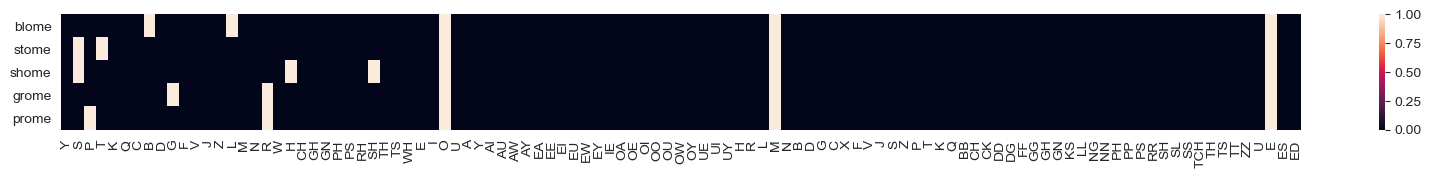

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 1.5))
sns.heatmap(pd.DataFrame({blome_data['orth']: blome_data['input'], 
                         **{blome_data[f'probe{i}']: blome_data[f'input_probe{i}'] for i in range(4)}},
                         index=grapheme_onset + grapheme_vowel + grapheme_codas).astype(float).T,
            xticklabels=True, ax=ax)
plt.show()

The correlation between the inputs for blome and its probes are as follows:

In [17]:
pd.DataFrame({blome_data['orth']: blome_data['input'], 
              **{blome_data[f'probe{i}']: blome_data[f'input_probe{i}'] for i in range(4)}}).corr()['blome'].iloc[1:]

stome    0.580000
shome    0.522958
grome    0.580000
prome    0.580000
Name: blome, dtype: float64

The target represntations are as follows:

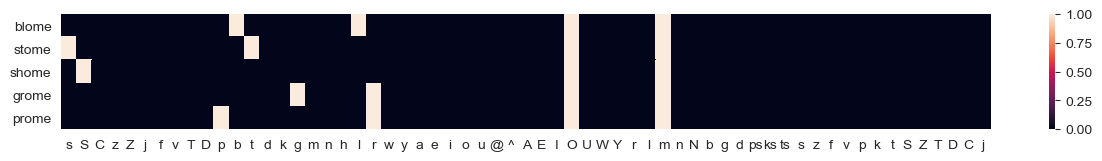

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 1.5))

sns.heatmap(pd.DataFrame({blome_data['orth']: blome_data['target'], 
                         **{blome_data[f'probe{i}']: blome_data[f'target_probe{i}'] for i in range(4)}},
                         index=phoneme_onset + phoneme_vowel + phoneme_codas).astype(float).T,
            annot_kws={"orientation": "horizontal"}, xticklabels=True, ax=ax)
plt.show()

The correlation between the targets for blome and its probes are as follows:

In [19]:
pd.DataFrame({blome_data['orth']: blome_data['target'], 
              **{blome_data[f'probe{i}']: blome_data[f'target_probe{i}'] for i in range(4)}}).corr()['blome'].iloc[1:]

stome    0.464912
shome    0.552269
grome    0.464912
prome    0.464912
Name: blome, dtype: float64

The two correlation vectors are here:

In [20]:
input_corr_vector = pd.DataFrame({blome_data['orth']: blome_data['input'], 
              **{blome_data[f'probe{i}']: blome_data[f'input_probe{i}'] for i in range(4)}}).corr()['blome'].iloc[1:].values
target_corr_vector = pd.DataFrame({blome_data['orth']: blome_data['target'], 
              **{blome_data[f'probe{i}']: blome_data[f'target_probe{i}'] for i in range(4)}}).corr()['blome'].iloc[1:].values
print("Input Correlation Vector:", input_corr_vector)
print("Target Correlation Vector:", target_corr_vector)

Input Correlation Vector: [0.58       0.52295779 0.58       0.58      ]
Target Correlation Vector: [0.46491228 0.55226896 0.46491228 0.46491228]


Finally, for the "correlation of correlations", we take the correlation between the two vectors above:

In [21]:
final_corr = np.corrcoef(input_corr_vector, target_corr_vector)[0, 1]
print(f"The Orth-Target correlation for blome and its probes is: {final_corr}")

The Orth-Target correlation for blome and its probes is: -1.0
